 # Assignment 2 - Modern CNNs (VGGNet)
*This notebook was run by Arsyi Syarief Aziz (H071191003) for the Introduction to Deep Learning course (Unhas) taught by Dr. Risman Adnan.*

This is part 2/7 of this week's assignment. In this notebook, I will attempt to implement VGGNet.

In [17]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.optim as optim
import torch.nn.functional as F

In [18]:
cuda = torch.device('cuda')

## Importing Dataset

I will use the MNIST dataset to train and test the model in this notebook. Because MNIST contains images of shape 28x28 pixels and because VGGNet accepts images of size 244x244 pixels, I will upscale each image in the dataset to 244x244 pixels.

In [19]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Resize(224)])
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Resize(224)]) # Upscale to 244x224 pixels
)


In [20]:
train_loader = torch.utils.data.DataLoader(
                 dataset=training_data,
                 batch_size=512,
                 shuffle=True,
                 num_workers=2,
                 pin_memory=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_data,
                batch_size=512,
                shuffle=False,
                num_workers=2,
                pin_memory=True)

Below are nine samples of the dataset

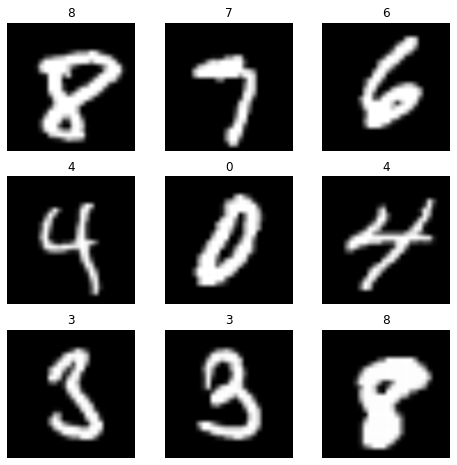

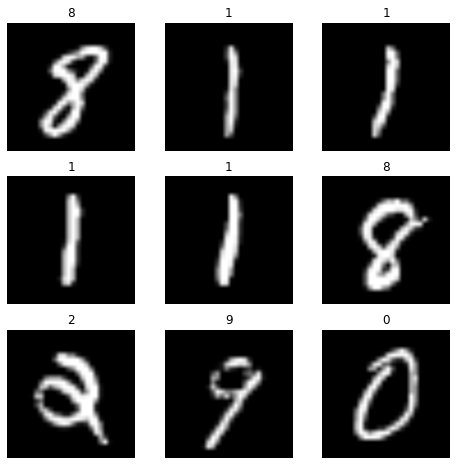

In [21]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Definining Helper Functions

The function below will be used to train the neural network

In [22]:
def train(net, train_loader, epochs=10, lr=0.001, momentum=0.9, weight_decay=0.0005): 

    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    criterion = nn.CrossEntropyLoss()

    net.to(cuda)
    
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0

        net.train()
        for X, y in train_loader:
            X, y = X.to(cuda), y.to(cuda)

            # zero the parameter gradients
            optimizer.zero_grad(set_to_none=True)

            # forward + backward + optimize
            outputs = net(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        print(f'Epoch: {epoch + 1}, loss: {running_loss / len(train_loader.dataset):.6f}')

    print('Finished Training')
    total, correct = test(net, train_loader)
    print(f'Train accuracy: {(correct/total)*100}%')

The function below will be used to calculate the neural network's test accuracy.

In [23]:
def test(net, test_loader):
    
    total = 0
    correct = 0

    for X, y in test_loader:
        net.eval()
        X, y = X.to(cuda), y.to(cuda)

        y_hat = net(X).argmax(axis=1)
        total += X.shape[0]
        correct += (y_hat == y).sum()

    return total, correct
  

## VGGNet

The second architecture that I will implement is VGGNet. 

VGGNet is similar to the previous CNN architecture (AlexNet), in which it contains: (1) convolutional layers; (2) a non linearity function; (3) max pooling layers; and (4) fully connected layers. However, what differentiates this architecture from AlexNet is that this architecture breaks down the convolutional layers into several VGG blocks.

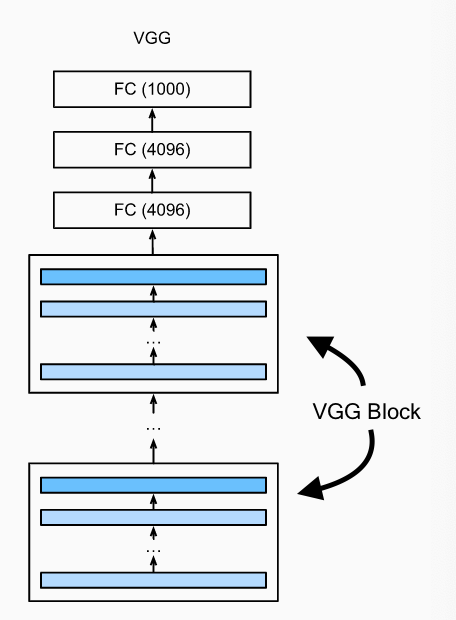

A single VGG block consists of a sequence of convolutional layers, followed by a single max-pooling layer.

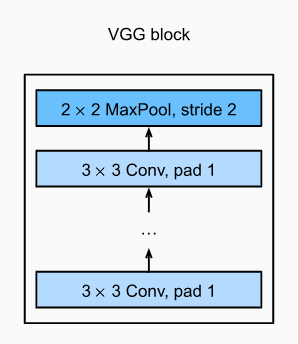

The original VGGNet consisted of five VGG blocks. The first two of these blocks each contained one convolutional layer, meanwhile, the remaining three blocks each contained two convolutional layers. The first block had 64 output channels and the subsequent blocks double the output channels until they reach a total of 512 output channels. 

Below is an implementation of a VGG block.

In [24]:
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

As explained above, these are the number of convolution layers and output channels for each VGG block (totalling five pairs or VGG blocks).

In [25]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

The code below combines the Convolutional layers with three fully connected layers.

In [26]:
def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    # The convolutional part
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # The fully-connected part
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

The code below simplifies VGGNet by reducing the number of output channels by a factor of 4. This is done to speed up training.

In [27]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
vgg_net = vgg(small_conv_arch)

I will train VGGNet with a learning rate of 0.05 and a total of 10 epochs.

In [12]:
train(vgg_net, train_loader, lr=0.05, epochs=10) 

Epoch: 1, loss: 0.004526
Epoch: 2, loss: 0.004499
Epoch: 3, loss: 0.004562
Epoch: 4, loss: 0.004526
Epoch: 5, loss: 0.004525
Epoch: 6, loss: 0.004281
Epoch: 7, loss: 0.000562
Epoch: 8, loss: 0.000175
Epoch: 9, loss: 0.000113
Epoch: 10, loss: 0.000096
Finished Training
Train accuracy: 99.05500030517578%


In [13]:
total, correct = test(vgg_net, test_loader)  

In [14]:
print(f"Test Accuracy: {(correct/total)*100}% ({correct}/{total})")

Test Accuracy: 98.62999725341797% (9863/10000)


As you can see, the trained VGGNet model has a test accuracy of 98.63%.

## Visualizing Predictions

Below are five visual representations of VGGNet's predictions.

In [15]:
def viz_results(net, dataset, num_samples=5):
    net.cpu()
    for i, (x, y) in enumerate(iter(dataset), 1):
        if i <= num_samples:
            
            x, y = x, y
            x = x.reshape(1, 1, x.shape[1], x.shape[2])

            y_hat = net(x).argmax()

            plt.imshow(x.reshape(x.shape[1], x.shape[2], -1).squeeze())
            plt.title(f'{i}. Actual: {y}; Predicted: {y_hat}')
            plt.show()
        else:
            break

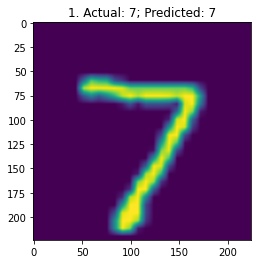

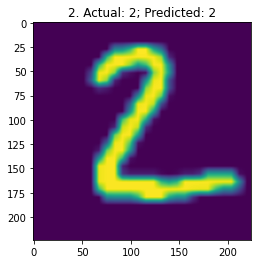

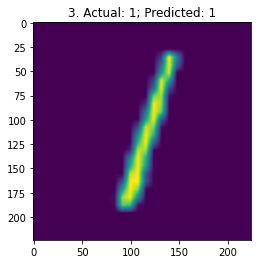

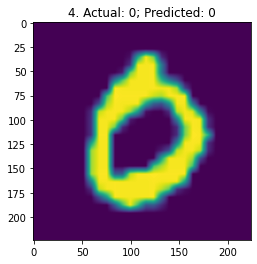

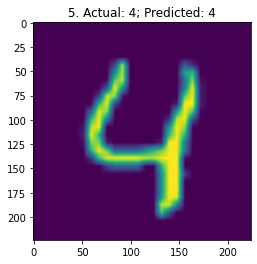

In [16]:
viz_results(vgg_net, test_data)